# Luderick Object Detection Using Pytorch Faster R-CNN (Inference)

## Load the preprocessed DataFrames generated in the preprocessing Notebook

In [1]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

plt.style.use('ggplot')

In [2]:
# Constants
MODELS_DIR = 'models'
IMAGES_DIR = 'Fish_automated_identification_and_counting/luderick-seagrass'
VIDEOS_DIR = 'Fish_automated_identification_and_counting/videos'
CLASSES = ['background', 'luderick']
NUM_CLASSES = len(CLASSES)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
INFERENCE_OUTPUT_DIR = 'inference_outputs'
!mkdir {INFERENCE_OUTPUT_DIR}

Ya existe el subdirectorio o el archivo inference_outputs.


In [3]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array
    """
    loaded_df = pd.read_csv(file_path)
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [4]:
validation_df = load_luderick_df('luderick_validation_preprocessed.csv')
test_df = load_luderick_df('luderick_test_preprocessed.csv')

validation_df

,image_name,video_name,frame_number,number_boxes,labels,bounding_boxes,area,segmentation
0,04C2_Luderick_16_000400.jpg,04C2_Luderick_16,1,1,[1],"[[2, 581, 163, 755]]",[28014],"[[163, 703, 146, 678, 125, 649, 93, 620, 58, 6..."
1,04C2_Luderick_16_000600.jpg,04C2_Luderick_16,2,1,[1],"[[2, 586, 223, 765]]",[39559],"[[223, 711, 218, 728, 195, 731, 131, 746, 107,..."
2,04C2_Luderick_16_000800.jpg,04C2_Luderick_16,3,1,[1],"[[0, 589, 281, 760]]",[48051],"[[281, 703, 279, 722, 237, 732, 165, 751, 98, ..."
3,04C2_Luderick_16_001000.jpg,04C2_Luderick_16,4,1,[1],"[[2, 588, 339, 748]]",[53920],"[[339, 700, 307, 711, 276, 726, 232, 737, 220,..."
4,04C2_Luderick_16_001200.jpg,04C2_Luderick_16,5,1,[1],"[[2, 580, 380, 746]]",[62748],"[[380, 678, 354, 646, 308, 607, 253, 581, 200,..."
...,...,...,...,...,...,...,...,...
819,C1_Luderick_14.mov_5fps_000013.jpg,C1_Luderick_14,13,3,"[1, 1, 1]","[[414, 235, 701, 432], [1584, 449, 1868, 590],...","[56539, 40044, 24924]","[[701, 235, 699, 250, 699, 273, 692, 310, 690,..."
820,C1_Luderick_14.mov_5fps_000014.jpg,C1_Luderick_14,14,3,"[1, 1, 1]","[[320, 254, 573, 449], [1457, 310, 1714, 451],...","[49335, 36237, 42000]","[[573, 254, 573, 271, 566, 314, 560, 335, 556,..."
821,C1_Luderick_14.mov_5fps_000015.jpg,C1_Luderick_14,15,4,"[1, 1, 1, 1]","[[1455, 476, 1737, 611], [1397, 304, 1697, 444...","[38070, 42000, 12314, 40425]","[[1716, 476, 1716, 504, 1722, 526, 1737, 570, ..."
822,C1_Luderick_14.mov_5fps_000016.jpg,C1_Luderick_14,16,3,"[1, 1, 1]","[[214, 314, 372, 504], [1325, 303, 1703, 442],...","[30020, 52542, 38676]","[[372, 314, 370, 327, 365, 344, 355, 372, 331,..."


## Convert images into tensors with transforms

In [5]:
# define the torchvision image transforms to transform an image into a tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
image_tensor = transform(Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000013.jpg"))
print(image_tensor)
print(image_tensor.shape)

tensor([[[0.1686, 0.1725, 0.1725,  ..., 0.4588, 0.4353, 0.4157],
         [0.1765, 0.1765, 0.1765,  ..., 0.4667, 0.4471, 0.4353],
         [0.1765, 0.1725, 0.1686,  ..., 0.4745, 0.4667, 0.4549],
         ...,
         [0.1176, 0.1176, 0.1216,  ..., 0.0549, 0.0588, 0.0588],
         [0.1176, 0.1216, 0.1255,  ..., 0.0549, 0.0667, 0.0667],
         [0.1176, 0.1216, 0.1255,  ..., 0.0588, 0.0706, 0.0745]],

        [[0.5608, 0.5647, 0.5647,  ..., 0.6980, 0.6745, 0.6549],
         [0.5686, 0.5686, 0.5686,  ..., 0.7059, 0.6863, 0.6745],
         [0.5686, 0.5647, 0.5608,  ..., 0.7137, 0.7059, 0.6941],
         ...,
         [0.3451, 0.3451, 0.3490,  ..., 0.1725, 0.1765, 0.1765],
         [0.3451, 0.3490, 0.3529,  ..., 0.1725, 0.1843, 0.1843],
         [0.3451, 0.3490, 0.3529,  ..., 0.1725, 0.1843, 0.1882]],

        [[0.5294, 0.5333, 0.5333,  ..., 0.6275, 0.6118, 0.5922],
         [0.5373, 0.5373, 0.5373,  ..., 0.6353, 0.6157, 0.6118],
         [0.5373, 0.5333, 0.5294,  ..., 0.6431, 0.6353, 0.

## Load The Faster RCNN Model with ResNet50-FPN Backbone

In [7]:
def load_model(num_classes, saved_model_dir, device, min_size=800):
    
    # load Faster RCNN pre-trained model
    # min_size = minimum size of the image to be rescaled before feeding it to the backbone (default = 800)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=min_size)
    
    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # define a new head for the detector with the required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    checkpoint = torch.load(saved_model_dir, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device).eval()
    
    return model

In [8]:
model_path = f"{MODELS_DIR}/best_model_MODEL_512_aug_1_epoch_16.pth" 
model = load_model(NUM_CLASSES, model_path, DEVICE)

In [9]:
# Visualize the model's prediction format
image = Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000013.jpg").convert('RGB')
image = transform(image).to(DEVICE)
image = image.unsqueeze(0)
outputs = model(image)
torch.cuda.empty_cache()
outputs

[{'boxes': tensor([[ 406.3866,  230.4159,  701.6923,  437.6280],
          [1582.7206,  434.0681, 1870.1034,  588.0568],
          [1518.2134,  319.3437, 1726.4779,  450.7162]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9991, 0.9987, 0.9981], device='cuda:0', grad_fn=<IndexBackward0>)}]

 ## Predict Function

In [10]:
def predict(image, model, device, detection_threshold):
    """
    Return, as arrays, the detection bounding boxes, labels, pred_scores and inference time in an PIL Image (RGB) using a 
    given model above a given detection_threshold.
    """
    # transform the image into a tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image) # get the predictions on the image
    end_time = time.time()
    inference_time = end_time - start_time
    
    # print the results individually
    # print(f"BOXES: {outputs[0]['boxes']}")
    # print(f"LABELS: {outputs[0]['labels']}")
    # print(f"SCORES: {outputs[0]['scores']}")
    
    # get the score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    high_score_indices = pred_scores >= detection_threshold
    
    pred_scores_high = pred_scores[high_score_indices]
    
    # get all the predicted labels
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_labels_high = pred_labels[high_score_indices]
    
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get the boxes above the threshold score
    pred_bboxes_high = pred_bboxes[high_score_indices].astype(np.int32)
    
    return pred_bboxes_high, pred_labels_high, pred_scores_high, inference_time

## Function to Draw Bounding Boxes Around an Object

A bounding box has a format of [x_min, y_min, x_max, y_max]

In [11]:
def draw_boxes(boxes, classes, labels, image, pred_scores, color=(255, 0, 0)):
    """
    Returns an image array that contains the predicted bounding boxes, labels and scores
    """
    # read the image with OpenCV
    image = np.asarray(image)
    for i, box in enumerate(boxes):
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                     color, 2)
        bbox_text = f"{classes[labels[i]]} {str(round(pred_scores[i]*100, 2))}" # showing probability scores
        #bbox_text = f"{classes[labels[i]]}"
        cv2.putText(image, bbox_text, (int(box[0]), int(box[1] - 5)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                   lineType=cv2.LINE_AA)
    
    return image

In [12]:
def view_image(image_array):
    """
    Display the image array
    """
    image = Image.fromarray((image_array).astype(np.uint8))  # Pil Image needs the image to be in int format
    display(image)

Inference time = 0.21799325942993164 seconds


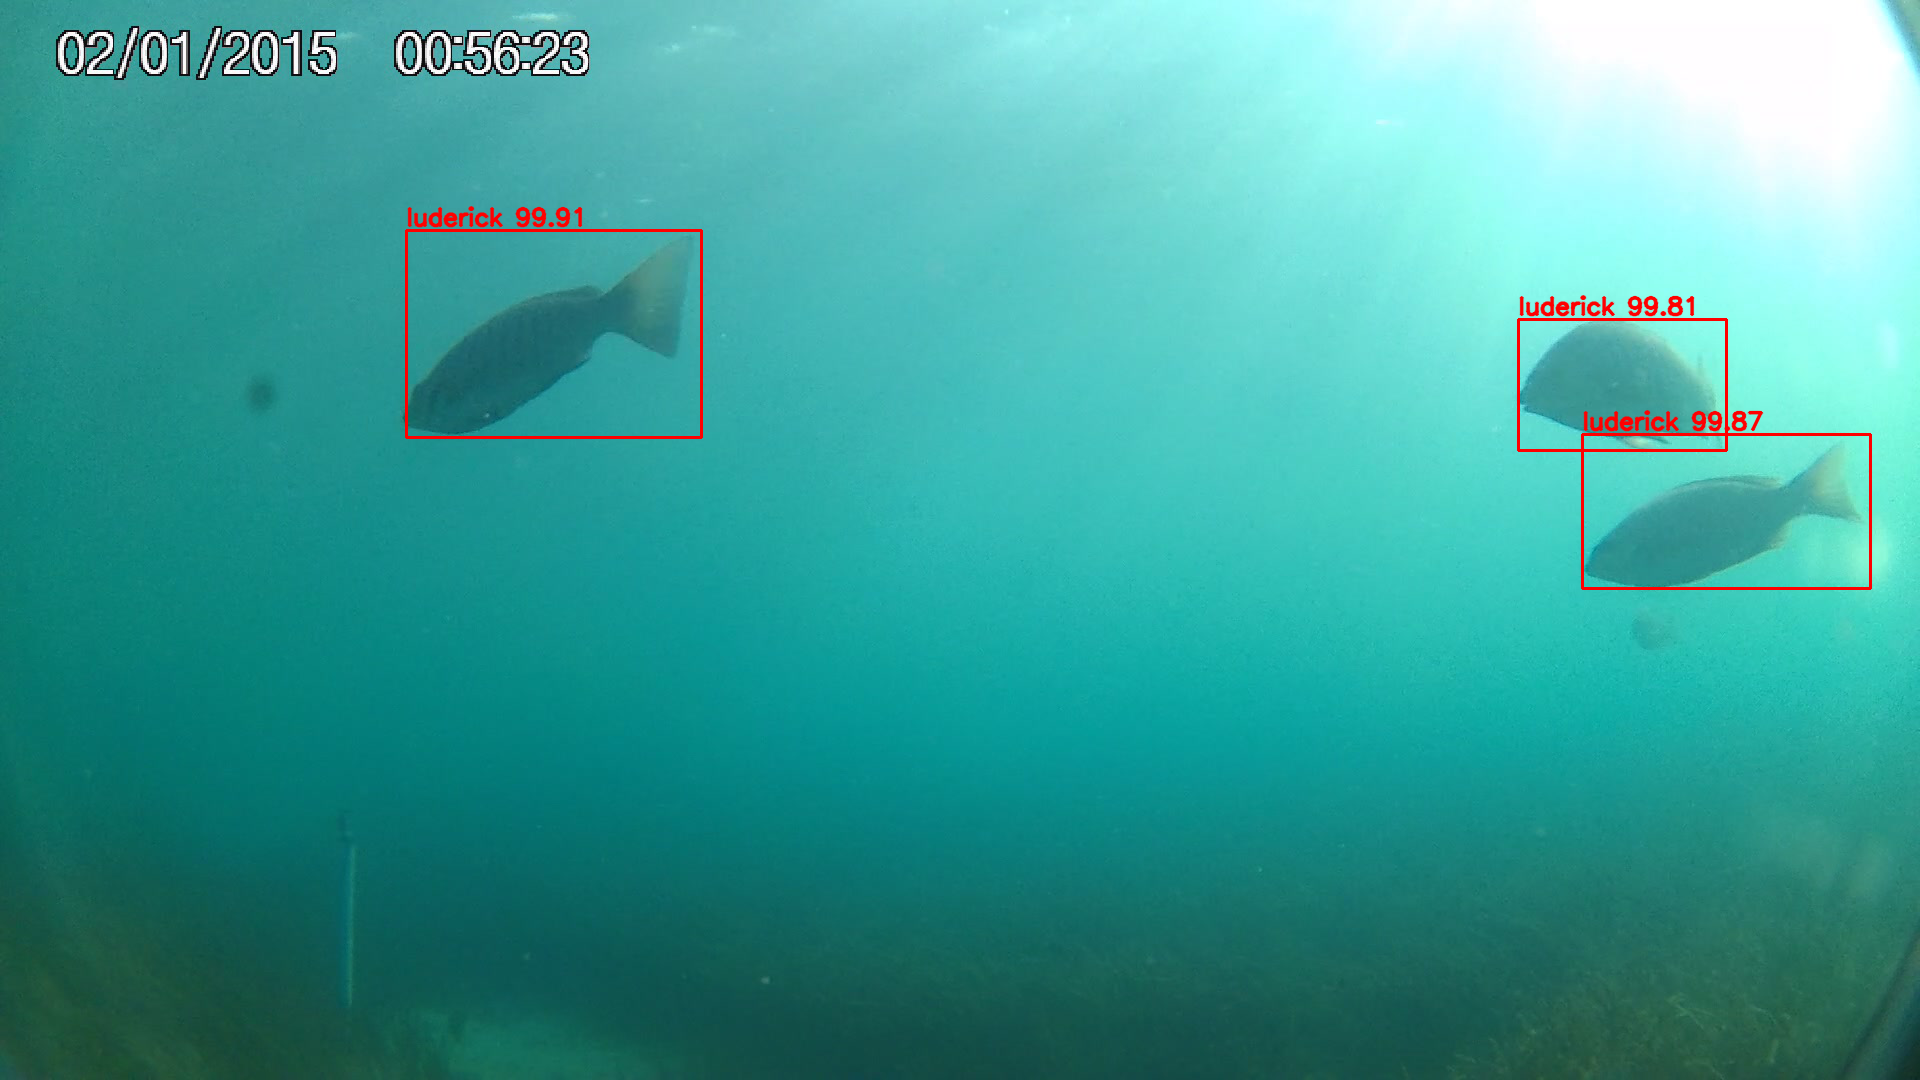

In [30]:
# visualize predicted bounding boxes from one image from the validation dataset

# Some PIL Images converted to arrays have 4 color channel unless .convert('RGB') is used
image = Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000013.jpg").convert('RGB') 
boxes, labels, pred_scores, inf_time = predict(image, model, DEVICE, 0.8)
image_boxes = draw_boxes(boxes, CLASSES, labels, image, pred_scores)
print(f'Inference time = {inf_time} seconds')
view_image(image_boxes)
torch.cuda.empty_cache()

## Inference on the full dataset

In [13]:
def predict_whole_dataset(luderick_df, model, images_dir, output_dir, score_threshold=0.8):
    """
    Carry out object detection on all the images from a preprocessed luderick dataset
    and save them with bounding boxes, labels and prediction scores printed at the desired folder
    """
    image_names = luderick_df['image_name'].values
    total_fps = 0
    frame_count = 0
    
    for i, image_name in enumerate(image_names):
            # load the image
            image = Image.open(f"{images_dir}/{image_name}").convert('RGB') 
            # use the model to get the predictions
            boxes, labels, pred_scores, inf_time = predict(image, model, DEVICE, score_threshold)
            # draw the image boxes
            image_boxes = draw_boxes(boxes, CLASSES, labels, image, pred_scores)
            # get the current fps
            fps = 1 / inf_time
            # increase total fps
            total_fps += fps
            # increment frame count
            frame_count += 1
            image_boxes = cv2.cvtColor(image_boxes, cv2.COLOR_BGR2RGB).astype(np.float32)
            cv2.imwrite(f"{output_dir}/{image_name}", image_boxes)
            print(f"Detection on image {i+1} finished...")
            print('-'*50)
    
    print('Dataset detection completed.')
    # calculate and print the average FPS
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}")

In [57]:
folder_name = 'validation_images_MODEL_512_aug_1'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..

output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"
predict_whole_dataset(validation_df, model, IMAGES_DIR, output_dir, 0.8)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


Ya existe el subdirectorio o el archivo validation_images_MODEL_512_aug_1.


Detection on image 1 finished...
--------------------------------------------------
Detection on image 2 finished...
--------------------------------------------------
Detection on image 3 finished...
--------------------------------------------------
Detection on image 4 finished...
--------------------------------------------------
Detection on image 5 finished...
--------------------------------------------------
Detection on image 6 finished...
--------------------------------------------------
Detection on image 7 finished...
--------------------------------------------------
Detection on image 8 finished...
--------------------------------------------------
Detection on image 9 finished...
--------------------------------------------------
Detection on image 10 finished...
--------------------------------------------------
Detection on image 11 finished...
--------------------------------------------------
Detection on image 12 finished...
----------------------------------------

Detection on image 98 finished...
--------------------------------------------------
Detection on image 99 finished...
--------------------------------------------------
Detection on image 100 finished...
--------------------------------------------------
Detection on image 101 finished...
--------------------------------------------------
Detection on image 102 finished...
--------------------------------------------------
Detection on image 103 finished...
--------------------------------------------------
Detection on image 104 finished...
--------------------------------------------------
Detection on image 105 finished...
--------------------------------------------------
Detection on image 106 finished...
--------------------------------------------------
Detection on image 107 finished...
--------------------------------------------------
Detection on image 108 finished...
--------------------------------------------------
Detection on image 109 finished...
---------------------

Detection on image 194 finished...
--------------------------------------------------
Detection on image 195 finished...
--------------------------------------------------
Detection on image 196 finished...
--------------------------------------------------
Detection on image 197 finished...
--------------------------------------------------
Detection on image 198 finished...
--------------------------------------------------
Detection on image 199 finished...
--------------------------------------------------
Detection on image 200 finished...
--------------------------------------------------
Detection on image 201 finished...
--------------------------------------------------
Detection on image 202 finished...
--------------------------------------------------
Detection on image 203 finished...
--------------------------------------------------
Detection on image 204 finished...
--------------------------------------------------
Detection on image 205 finished...
-------------------

Detection on image 290 finished...
--------------------------------------------------
Detection on image 291 finished...
--------------------------------------------------
Detection on image 292 finished...
--------------------------------------------------
Detection on image 293 finished...
--------------------------------------------------
Detection on image 294 finished...
--------------------------------------------------
Detection on image 295 finished...
--------------------------------------------------
Detection on image 296 finished...
--------------------------------------------------
Detection on image 297 finished...
--------------------------------------------------
Detection on image 298 finished...
--------------------------------------------------
Detection on image 299 finished...
--------------------------------------------------
Detection on image 300 finished...
--------------------------------------------------
Detection on image 301 finished...
-------------------

Detection on image 386 finished...
--------------------------------------------------
Detection on image 387 finished...
--------------------------------------------------
Detection on image 388 finished...
--------------------------------------------------
Detection on image 389 finished...
--------------------------------------------------
Detection on image 390 finished...
--------------------------------------------------
Detection on image 391 finished...
--------------------------------------------------
Detection on image 392 finished...
--------------------------------------------------
Detection on image 393 finished...
--------------------------------------------------
Detection on image 394 finished...
--------------------------------------------------
Detection on image 395 finished...
--------------------------------------------------
Detection on image 396 finished...
--------------------------------------------------
Detection on image 397 finished...
-------------------

Detection on image 482 finished...
--------------------------------------------------
Detection on image 483 finished...
--------------------------------------------------
Detection on image 484 finished...
--------------------------------------------------
Detection on image 485 finished...
--------------------------------------------------
Detection on image 486 finished...
--------------------------------------------------
Detection on image 487 finished...
--------------------------------------------------
Detection on image 488 finished...
--------------------------------------------------
Detection on image 489 finished...
--------------------------------------------------
Detection on image 490 finished...
--------------------------------------------------
Detection on image 491 finished...
--------------------------------------------------
Detection on image 492 finished...
--------------------------------------------------
Detection on image 493 finished...
-------------------

Detection on image 578 finished...
--------------------------------------------------
Detection on image 579 finished...
--------------------------------------------------
Detection on image 580 finished...
--------------------------------------------------
Detection on image 581 finished...
--------------------------------------------------
Detection on image 582 finished...
--------------------------------------------------
Detection on image 583 finished...
--------------------------------------------------
Detection on image 584 finished...
--------------------------------------------------
Detection on image 585 finished...
--------------------------------------------------
Detection on image 586 finished...
--------------------------------------------------
Detection on image 587 finished...
--------------------------------------------------
Detection on image 588 finished...
--------------------------------------------------
Detection on image 589 finished...
-------------------

Detection on image 674 finished...
--------------------------------------------------
Detection on image 675 finished...
--------------------------------------------------
Detection on image 676 finished...
--------------------------------------------------
Detection on image 677 finished...
--------------------------------------------------
Detection on image 678 finished...
--------------------------------------------------
Detection on image 679 finished...
--------------------------------------------------
Detection on image 680 finished...
--------------------------------------------------
Detection on image 681 finished...
--------------------------------------------------
Detection on image 682 finished...
--------------------------------------------------
Detection on image 683 finished...
--------------------------------------------------
Detection on image 684 finished...
--------------------------------------------------
Detection on image 685 finished...
-------------------

Detection on image 770 finished...
--------------------------------------------------
Detection on image 771 finished...
--------------------------------------------------
Detection on image 772 finished...
--------------------------------------------------
Detection on image 773 finished...
--------------------------------------------------
Detection on image 774 finished...
--------------------------------------------------
Detection on image 775 finished...
--------------------------------------------------
Detection on image 776 finished...
--------------------------------------------------
Detection on image 777 finished...
--------------------------------------------------
Detection on image 778 finished...
--------------------------------------------------
Detection on image 779 finished...
--------------------------------------------------
Detection on image 780 finished...
--------------------------------------------------
Detection on image 781 finished...
-------------------

In [14]:
# try using a model with smaller min_size to check if it gets more fps
model = load_model(NUM_CLASSES, model_path, DEVICE, min_size=256)

In [60]:
folder_name = 'validation_images_MODEL_512_aug_1_min_size_512'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..

output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"
predict_whole_dataset(validation_df, model, IMAGES_DIR, output_dir, 0.8)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass
Detection on image 1 finished...
--------------------------------------------------
Detection on image 2 finished...
--------------------------------------------------
Detection on image 3 finished...
--------------------------------------------------
Detection on image 4 finished...
--------------------------------------------------
Detection on image 5 finished...
--------------------------------------------------
Detection on image 6 finished...
--------------------------------------------------
Detection on image 7 finished...
--------------------------------------------------
Detection on image 8 finished...
--------------------------------------------------
Detection on image 9 finished...
--------------------------------------------------
Detection on image 10 finished...
--------------------------------------------------
Detection on im

Detection on image 96 finished...
--------------------------------------------------
Detection on image 97 finished...
--------------------------------------------------
Detection on image 98 finished...
--------------------------------------------------
Detection on image 99 finished...
--------------------------------------------------
Detection on image 100 finished...
--------------------------------------------------
Detection on image 101 finished...
--------------------------------------------------
Detection on image 102 finished...
--------------------------------------------------
Detection on image 103 finished...
--------------------------------------------------
Detection on image 104 finished...
--------------------------------------------------
Detection on image 105 finished...
--------------------------------------------------
Detection on image 106 finished...
--------------------------------------------------
Detection on image 107 finished...
-----------------------

Detection on image 192 finished...
--------------------------------------------------
Detection on image 193 finished...
--------------------------------------------------
Detection on image 194 finished...
--------------------------------------------------
Detection on image 195 finished...
--------------------------------------------------
Detection on image 196 finished...
--------------------------------------------------
Detection on image 197 finished...
--------------------------------------------------
Detection on image 198 finished...
--------------------------------------------------
Detection on image 199 finished...
--------------------------------------------------
Detection on image 200 finished...
--------------------------------------------------
Detection on image 201 finished...
--------------------------------------------------
Detection on image 202 finished...
--------------------------------------------------
Detection on image 203 finished...
-------------------

Detection on image 288 finished...
--------------------------------------------------
Detection on image 289 finished...
--------------------------------------------------
Detection on image 290 finished...
--------------------------------------------------
Detection on image 291 finished...
--------------------------------------------------
Detection on image 292 finished...
--------------------------------------------------
Detection on image 293 finished...
--------------------------------------------------
Detection on image 294 finished...
--------------------------------------------------
Detection on image 295 finished...
--------------------------------------------------
Detection on image 296 finished...
--------------------------------------------------
Detection on image 297 finished...
--------------------------------------------------
Detection on image 298 finished...
--------------------------------------------------
Detection on image 299 finished...
-------------------

Detection on image 384 finished...
--------------------------------------------------
Detection on image 385 finished...
--------------------------------------------------
Detection on image 386 finished...
--------------------------------------------------
Detection on image 387 finished...
--------------------------------------------------
Detection on image 388 finished...
--------------------------------------------------
Detection on image 389 finished...
--------------------------------------------------
Detection on image 390 finished...
--------------------------------------------------
Detection on image 391 finished...
--------------------------------------------------
Detection on image 392 finished...
--------------------------------------------------
Detection on image 393 finished...
--------------------------------------------------
Detection on image 394 finished...
--------------------------------------------------
Detection on image 395 finished...
-------------------

Detection on image 480 finished...
--------------------------------------------------
Detection on image 481 finished...
--------------------------------------------------
Detection on image 482 finished...
--------------------------------------------------
Detection on image 483 finished...
--------------------------------------------------
Detection on image 484 finished...
--------------------------------------------------
Detection on image 485 finished...
--------------------------------------------------
Detection on image 486 finished...
--------------------------------------------------
Detection on image 487 finished...
--------------------------------------------------
Detection on image 488 finished...
--------------------------------------------------
Detection on image 489 finished...
--------------------------------------------------
Detection on image 490 finished...
--------------------------------------------------
Detection on image 491 finished...
-------------------

Detection on image 576 finished...
--------------------------------------------------
Detection on image 577 finished...
--------------------------------------------------
Detection on image 578 finished...
--------------------------------------------------
Detection on image 579 finished...
--------------------------------------------------
Detection on image 580 finished...
--------------------------------------------------
Detection on image 581 finished...
--------------------------------------------------
Detection on image 582 finished...
--------------------------------------------------
Detection on image 583 finished...
--------------------------------------------------
Detection on image 584 finished...
--------------------------------------------------
Detection on image 585 finished...
--------------------------------------------------
Detection on image 586 finished...
--------------------------------------------------
Detection on image 587 finished...
-------------------

Detection on image 672 finished...
--------------------------------------------------
Detection on image 673 finished...
--------------------------------------------------
Detection on image 674 finished...
--------------------------------------------------
Detection on image 675 finished...
--------------------------------------------------
Detection on image 676 finished...
--------------------------------------------------
Detection on image 677 finished...
--------------------------------------------------
Detection on image 678 finished...
--------------------------------------------------
Detection on image 679 finished...
--------------------------------------------------
Detection on image 680 finished...
--------------------------------------------------
Detection on image 681 finished...
--------------------------------------------------
Detection on image 682 finished...
--------------------------------------------------
Detection on image 683 finished...
-------------------

Detection on image 768 finished...
--------------------------------------------------
Detection on image 769 finished...
--------------------------------------------------
Detection on image 770 finished...
--------------------------------------------------
Detection on image 771 finished...
--------------------------------------------------
Detection on image 772 finished...
--------------------------------------------------
Detection on image 773 finished...
--------------------------------------------------
Detection on image 774 finished...
--------------------------------------------------
Detection on image 775 finished...
--------------------------------------------------
Detection on image 776 finished...
--------------------------------------------------
Detection on image 777 finished...
--------------------------------------------------
Detection on image 778 finished...
--------------------------------------------------
Detection on image 779 finished...
-------------------

## Inference on videos

In [15]:
def detect_video(video_path, model, device, output_dir='.', detection_threshold=0.8, save_video=True):
    """
    Carries out detection on a video frame by frame, showing it in real time in an opencv window and showing the framerate. 
    It also saves the video at 30 fps as a .mp4
    """
    cap = cv2.VideoCapture(video_path)
    
    if (cap.isOpened() == False):
        print('Error while trying to read video. Please check path again')
    
    # get the frame width and height
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    
    save_name = f"{video_path.split('/')[-1].split('.')[0]}"
    # define codec and create VideoWriter object
    if save_video:
        out = cv2.VideoWriter(f"{output_dir}/{save_name}.mp4",
                             cv2.VideoWriter_fourcc(*'mp4v'), 30,
                             (frame_width, frame_height))
    
    frame_count = 0 # to count total frames
    total_fps = 0 # to get the final frames per second
    
    # Reading Frames and Detecting Objects
    # read until end of video
    while(cap.isOpened()):
        # capture each frame of the video
        ret, frame = cap.read()
        # while the video isn't finished...
        if ret:
            # get the start time for real time fps
            start_time = time.time()
            with torch.no_grad():
                # get predictions for the current frame
                boxes, labels, pred_scores, inf_time = predict(frame, model, device, detection_threshold)
            
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)
            # draw boxes and show current frame on screen
            image = draw_boxes(boxes, CLASSES, labels, frame, pred_scores, color=(0, 0, 255))
            # get the end time
            end_time = time.time()
            # get the real time fps
            fps = 1 / (end_time - start_time)
            # add fps tot total fps
            total_fps += fps
            # increment frame count
            frame_count += 1
            image = cv2.putText(image, f"{fps:.1f} FPS", 
                        (image.shape[1]-200, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 
                        2, lineType=cv2.LINE_AA)
            
            # Display frames in a window
            # press 'q' to exit
            wait_time = max(1, int(fps/4))
            cv2.imshow('image', image)
            if save_video:
                out.write(image)
            if cv2.waitKey(wait_time) & 0xFF == ord('q'):
                break
                
        else:
            break
      
    # release VideoCapture()
    cap.release()
    # close all frames and video windows
    cv2.destroyAllWindows()
    
    # calculate and print the average fps
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}")

In [67]:
folder_name = 'validation_video_MODEL_512_aug_1'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..
video_path = f"{VIDEOS_DIR}/validation/2205_Luderick_25.mov"
output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"

detect_video(video_path, model, DEVICE, output_dir, detection_threshold=0.6, save_video=False)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


Ya existe el subdirectorio o el archivo validation_video_MODEL_512_aug_1.


Average FPS: 10.369


## Model Evaluation using Mean Average Precision (mAP)

### Function to compute the Intersection Over Union (IOU)

The IOU is the ratio between the area of the intersection between two boxes and the area of their union

In [30]:
def IOU(box_1, box_2):
    """
    Computes the Intersection Over Union (IOU) between two bounding boxes formatted as [x_min, y_min, x_max, y_max]
    """
    # get the right-most left edge between the two bounding boxes
    max_left = max(box_1[0], box_2[0])
    # get the left-most right edge between the two bounding boxes
    min_right = min(box_1[2], box_2[2])
    # compute the intersection width
    intersection_width = min_right - max_left
    
    # get the lowest top edge (y is bigger as it goes lower)
    max_top = max(box_1[1], box_2[1])
    # get the highest bottom edge
    min_bottom = min(box_1[3], box_2[3])
    # compute the intersection height
    intersection_height = min_bottom - max_top
    
    # if the boxes don't intersect, intersection_width or height will be negative
    intersection_area = max(0, intersection_width) * max(0, intersection_height)
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    # get the union area by adding the boxes areas and substracting their intersection
    union_area = box_1_area + box_2_area - intersection_area
    # get the final iou
    iou = intersection_area / union_area
    
    return iou

### Functions to generate a dataframe with info of each predicted bounding box
It includes:
 * Name of the image where the predicted box is
 * Label id of the prediction (class id)
 * Confidence score of the prediction
 * The ground truth box id (in respect to the image) with the highest IOU (-1 if none found)
 * The highest IOU with any ground truth box

In [31]:
def get_image_box_evaluation_dataframe(pred_boxes, true_boxes, true_labels, pred_label, pred_scores):
    """
    Returns the box evaluation dataframe of a single image and class
    """
    ious_gt_box_index = np.array([-1] * len(pred_boxes))
    ious = np.zeros(len(pred_boxes))
    
    for i, pred_box in enumerate(pred_boxes):
        max_iou = 0
        max_iou_box_index = -1
        for j, true_box in enumerate(true_boxes):
            iou = IOU(pred_box, true_box)
            if iou > max_iou and true_labels[j] == pred_label:
                max_iou = iou
                # save the index of the true box with highest iou
                max_iou_box_index = j
        
        ious[i] = max_iou
        ious_gt_box_index[i] = max_iou_box_index

    output_df = pd.DataFrame({'confidence': pred_scores,'IOU': ious,'GT_Box': ious_gt_box_index})
    
    return output_df

In [32]:
def get_boxes_evaluation_dataframe(model, device, luderick_df, images_dir, num_classes, detection_threshold):
    """
    Returns the box evaluation dataframe
    """
    image_names = luderick_df['image_name'].values
    num_images = len(image_names)
    all_boxes_eval_df = pd.DataFrame()
    completion_count = 0
    for i, image_name in enumerate(image_names):
        if i % int(num_images/4) == 0:
            print(f'{completion_count}% of images processed')
            completion_count += 25
        # load the image
        image = Image.open(f"{images_dir}/{image_name}").convert('RGB') 
        # use the model to get the predictions
        pred_boxes, pred_labels, pred_scores, inf_time = predict(image, model, device, detection_threshold)
        true_boxes = luderick_df.iloc[i]['bounding_boxes']
        true_labels = luderick_df.iloc[i]['labels']
        for label in range(num_classes):
            # check if each box is a true positive or false positive
            class_indices = np.array(pred_labels) == label
            # use all the boxes from class i as input to get an array of their ious
            # and a boolean list indicating if the predicted class is correct
            image_boxes_eval_df = get_image_box_evaluation_dataframe(pred_boxes[class_indices], 
                                            true_boxes, true_labels, label, pred_scores[class_indices])
            image_boxes_eval_df['image_name'] = [image_name]*len(pred_boxes[class_indices])
            image_boxes_eval_df['label_id'] = [label]*len(pred_boxes[class_indices])
            image_boxes_eval_df = image_boxes_eval_df[['image_name', 'label_id', 'confidence', 'GT_Box', 'IOU']]
            all_boxes_eval_df = pd.concat([all_boxes_eval_df, image_boxes_eval_df], ignore_index=True)
    
    return all_boxes_eval_df

In [19]:
box_eval_df = get_boxes_evaluation_dataframe(model, DEVICE, validation_df, IMAGES_DIR, NUM_CLASSES, detection_threshold=0.01)

0% of images processed
25% of images processed
50% of images processed
75% of images processed


In [38]:
box_eval_df

,image_name,label_id,confidence,GT_Box,IOU
0,04C2_Luderick_16_000400.jpg,1.0,0.993775,0.0,0.948097
1,04C2_Luderick_16_000400.jpg,1.0,0.220970,-1.0,0.000000
2,04C2_Luderick_16_000400.jpg,1.0,0.122255,-1.0,0.000000
3,04C2_Luderick_16_000600.jpg,1.0,0.996549,0.0,0.885086
4,04C2_Luderick_16_000600.jpg,1.0,0.080668,-1.0,0.000000
...,...,...,...,...,...
2107,C1_Luderick_14.mov_5fps_000016.jpg,1.0,0.998660,2.0,0.891118
2108,C1_Luderick_14.mov_5fps_000016.jpg,1.0,0.998467,1.0,0.854480
2109,C1_Luderick_14.mov_5fps_000016.jpg,1.0,0.997568,-1.0,0.000000
2110,C1_Luderick_14.mov_5fps_000016.jpg,1.0,0.996231,0.0,0.838008


### Assign True Positive or False Positive

Given a IOU threshold, if the IOU is above that threshold, the predicted box will be considered a true positive (TP = 1) or False Positve (TP = 0) otherwise

In [33]:
def assign_tp_fp(boxes_eval_df, iou_thresh):
    """
    Check if every predicted box is a true positive (TP) or a false positive (FP) for a given IOU threshold
    and set the TP column to 1 or 0 accordingly
    """
    boxes_eval_df = boxes_eval_df.sort_values(by='confidence', ascending=False)
    boxes_eval_df = boxes_eval_df.reset_index(drop=True)
    gt_boxes_checked = []
    for index, row in boxes_eval_df.iterrows():
        gt_box_id = f"{row['image_name']}_box_{row['GT_Box']}"
        # assignt TP if the pred_box intersects with a GT box and has higher IOU than the threshold
        if row['GT_Box'] != -1 \
            and row['IOU'] > iou_thresh \
                and not(gt_box_id in gt_boxes_checked): # dont mark as TP if another pred_box is TP on the same GT box
                    boxes_eval_df.at[index, 'TP'] = 1
                    gt_boxes_checked.append(gt_box_id)
                    
        else:
            ## add false positive
            boxes_eval_df.at[index, 'TP'] = 0
    
    return boxes_eval_df

In [34]:
TP_df = assign_tp_fp(box_eval_df, 0.5)
TP_df

,image_name,label_id,confidence,GT_Box,IOU,TP
0,04C4_Luderick_25.mov_5fps_000011.jpg,1.0,0.999672,0.0,0.956599,1.0
1,27C3_Luderick_30.mov_5fps_000019.jpg,1.0,0.999657,0.0,0.941160,1.0
2,2205_Luderick_25.mov_5fps_000091.jpg,1.0,0.999654,0.0,0.854590,1.0
3,2205_Luderick_25.mov_5fps_000141.jpg,1.0,0.999631,0.0,0.899627,1.0
4,27C3_Luderick_30.mov_5fps_000018.jpg,1.0,0.999626,0.0,0.945412,1.0
...,...,...,...,...,...,...
2107,2205_Luderick_50.mov_5fps_000006.jpg,1.0,0.050522,-1.0,0.000000,0.0
2108,2205_Luderick_25.mov_5fps_000041.jpg,1.0,0.050379,5.0,0.491430,0.0
2109,2205_Luderick_25.mov_5fps_000061.jpg,1.0,0.050093,13.0,0.353808,0.0
2110,2205_Luderick_25.mov_5fps_000198.jpg,1.0,0.050078,3.0,0.671362,1.0


### Compute precision and recall for a given class

 *  The precision is the ratio of predicted true positives between all the predicted positives.
        * precision = true_positives / (true_positives + false_positives)
    
 * The recall is the ratio of predicted true positives between all the ground truth positives.
        * recall = true_positives / (true_positives + false_negatives) = true_positives / num_gt_boxes
        
Both are computed step by step, starting from the highest confidence score predicted box

In [35]:
def assign_class_precision_recall(TP_df, class_id, num_gt_boxes):
    """
    Assign precision and recall ot the dataframe iteratively
    """
    # use only the boxes with the deriser class label
    prec_rec_df = TP_df[TP_df['label_id'] == class_id]
    prec_rec_df = prec_rec_df.sort_values(by='confidence', ascending=False)
    prec_rec_df = prec_rec_df.reset_index(drop=True)
    
    tp_count = 0
    for index, row in prec_rec_df.iterrows():
        # increase the total true positive count
        tp_count += row['TP']
        
        # precision = true positives / (true positives + false positves)
        # each row is either a true positives or a false positive, 
        # so precision = tp_count / index+1
        prec_rec_df.at[index, 'Precision'] = tp_count / (index+1)
        
        # recall = true positives / num_gt_boxes
        prec_rec_df.at[index, 'Recall'] = tp_count / num_gt_boxes
  
    return prec_rec_df

In [36]:
def get_total_gt_boxes(luderick_preprocessed_df, class_id):
    """
    Returns the total number of ground truth boxes in a luderick preprocessed dataframe with a given class id
    """
    # get how many gt boxes of that class_id appear in each image
    gt_boxes_per_image = [np.count_nonzero(np.array(x) == class_id) for x in luderick_preprocessed_df['labels'].values]
    # add all the results to get the total gt boxes of that class
    return sum(gt_boxes_per_image)

In [37]:
# get the total gt boxes in validation_df for the luderick class (label=1)
num_gt_boxes = get_total_gt_boxes(validation_df, 1)
print(f'Num gt boxes = {num_gt_boxes}')
# get the precision-recall dataframe
prec_rec_df = assign_class_precision_recall(TP_df, 1, num_gt_boxes)
prec_rec_df

Num gt boxes = 1632


,image_name,label_id,confidence,GT_Box,IOU,TP,Precision,Recall
0,04C4_Luderick_25.mov_5fps_000011.jpg,1.0,0.999672,0.0,0.956599,1.0,1.000000,0.000613
1,27C3_Luderick_30.mov_5fps_000019.jpg,1.0,0.999657,0.0,0.941160,1.0,1.000000,0.001225
2,2205_Luderick_25.mov_5fps_000091.jpg,1.0,0.999654,0.0,0.854590,1.0,1.000000,0.001838
3,2205_Luderick_25.mov_5fps_000141.jpg,1.0,0.999631,0.0,0.899627,1.0,1.000000,0.002451
4,27C3_Luderick_30.mov_5fps_000018.jpg,1.0,0.999626,0.0,0.945412,1.0,1.000000,0.003064
...,...,...,...,...,...,...,...,...
2107,2205_Luderick_50.mov_5fps_000006.jpg,1.0,0.050522,-1.0,0.000000,0.0,0.735769,0.950368
2108,2205_Luderick_25.mov_5fps_000041.jpg,1.0,0.050379,5.0,0.491430,0.0,0.735420,0.950368
2109,2205_Luderick_25.mov_5fps_000061.jpg,1.0,0.050093,13.0,0.353808,0.0,0.735071,0.950368
2110,2205_Luderick_25.mov_5fps_000198.jpg,1.0,0.050078,3.0,0.671362,1.0,0.735197,0.950980


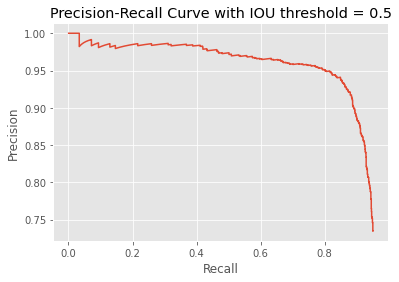

In [38]:
# plot the precision recall curve
plt.plot(prec_rec_df['Recall'], prec_rec_df['Precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve with IOU threshold = 0.5')
plt.show();

### Function to get the final class Precision and Recall dataframe given a box_eval_df and an IOU threshold

In [39]:
def get_threshold_prec_recall(box_eval_df, iou_threshold, class_id, num_gt_boxes):
    """
    Returns the final Precision and Recall dataframe given a box_eval_df and an IOU threshold   
    """
    out_df = assign_tp_fp(box_eval_df, iou_threshold)
    out_df = assign_class_precision_recall(out_df, class_id, num_gt_boxes)
    return out_df

In [40]:
# get the total gt boxes in validation_df for the luderick class (label=1) at different iou thresholds
num_gt_boxes = get_total_gt_boxes(validation_df, 1)
thres_prec_rec_df_50 = get_threshold_prec_recall(box_eval_df, 0.5, 1, num_gt_boxes)
thres_prec_rec_df_60 = get_threshold_prec_recall(box_eval_df, 0.6, 1, num_gt_boxes)
thres_prec_rec_df_70 = get_threshold_prec_recall(box_eval_df, 0.7, 1, num_gt_boxes)
thres_prec_rec_df_80 = get_threshold_prec_recall(box_eval_df, 0.8, 1, num_gt_boxes)
thres_prec_rec_df_90 = get_threshold_prec_recall(box_eval_df, 0.9, 1, num_gt_boxes)

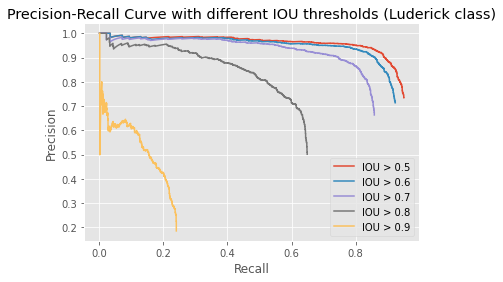

In [41]:
# plot the precision recall curve
plt.plot(thres_prec_rec_df_50['Recall'], thres_prec_rec_df_50['Precision'], label = 'IOU > 0.5')
plt.plot(thres_prec_rec_df_60['Recall'], thres_prec_rec_df_60['Precision'], label = 'IOU > 0.6')
plt.plot(thres_prec_rec_df_70['Recall'], thres_prec_rec_df_70['Precision'], label = 'IOU > 0.7')
plt.plot(thres_prec_rec_df_80['Recall'], thres_prec_rec_df_80['Precision'], label = 'IOU > 0.8')
plt.plot(thres_prec_rec_df_90['Recall'], thres_prec_rec_df_90['Precision'], label = 'IOU > 0.9')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve with different IOU thresholds (Luderick class)')
plt.legend()
plt.show();

### Average Precision (AP)

The AP is equal to the numerical integration of the Precision-Recall curve = area under the curve.

In [42]:
def compute_trapezoid_integral(point_a, point_b):
    """
    Computes the trapezoidal numerical integration between two points
    Which is the area of the trapezoid formed by the two points and the x-axis
    where the altitude is (point_b_x - point_a_x) and point_a_y and point_b_y are the two bases
    area_trapezoid = (1/2)*(point_b_x - point_a_x)*(point_a_y + point_b_y)
    """
    return (1/2)*(point_b[0] - point_a[0])*(point_a[1] + point_b[1])

In [43]:
def compute_class_AP(precision_list, recall_list):
    """
    Returns the average precision of a class with a list of precisions and recalls as input
    """
    total_ap = 0
    # start at i = 1 as the trapezoidal rule needs the previous point
    for i in range(1, len(precision_list)):
        # recall is the x-axis and precision the y_axis
        point_a = (recall_list[i-1], precision_list[i-1])
        point_b = (recall_list[i], precision_list[i])
        # compute the area under the two points
        ap = compute_trapezoid_integral(point_a, point_b)
        # add to the total area
        total_ap += ap
    
    return total_ap

In [44]:
ap_50 = compute_class_AP(thres_prec_rec_df_50['Precision'], thres_prec_rec_df_50['Recall'])
ap_60 = compute_class_AP(thres_prec_rec_df_60['Precision'], thres_prec_rec_df_60['Recall'])
ap_70 = compute_class_AP(thres_prec_rec_df_70['Precision'], thres_prec_rec_df_70['Recall'])
ap_80 = compute_class_AP(thres_prec_rec_df_80['Precision'], thres_prec_rec_df_80['Recall'])
ap_90 = compute_class_AP(thres_prec_rec_df_90['Precision'], thres_prec_rec_df_90['Recall'])
print(f'(IOU > 0.5) AP = {ap_50}')
print(f'(IOU > 0.6) AP = {ap_60}')
print(f'(IOU > 0.7) AP = {ap_70}')
print(f'(IOU > 0.8) AP = {ap_80}')
print(f'(IOU > 0.9) AP = {ap_90}')

(IOU > 0.5) AP = 0.9159549228072671
(IOU > 0.6) AP = 0.8845375225253108
(IOU > 0.7) AP = 0.8106956198680415
(IOU > 0.8) AP = 0.5684005687726046
(IOU > 0.9) AP = 0.1287641620701785


### Mean Average Precision (mAP)

 * For each class, get the AP at different IOU thresholds (by recomputing the True Positives) and calculate its mean
     * The general IOU threshold range for mAP computation is from 0.5 to 0.95 with step=0.05 (COCO dataset evaluation)
     * The mAPs single IOU thresholds of 0.5 and 0.75 are usually used as well to 
 * Calculate the mean between the results of each class


In [45]:
def compute_mAp(box_eval_df, preprocessed_df, num_classes):
    """
    Returns the following metrics of a given box evaluation dataframe and the original preprocessed dataframe:
    - mAP@0.5:0.05:0.95
    - mAp@.50
    - mAP@.75 
    """
    # initialize the trhesholds array [0.5, 0.55, ... 0.90, 0.95]
    iou_thresholds = np.arange(0.5, 1, step=0.05)
    
    class_mAP_list = []
    class_mAP50_list = []
    class_mAP75_list = []
    # iterate over the classes avoiding the 0 class (background)
    for i in range(1, num_classes):
        iou_trheshold_ap_list = []
        num_gt_boxes = get_total_gt_boxes(preprocessed_df, i)
        for iou_threshold in iou_thresholds:
            # get the precision-recall dataframe
            prec_rec_df = get_threshold_prec_recall(box_eval_df, iou_threshold, i, num_gt_boxes)
            # get the average precision for this threshold
            ap = compute_class_AP(prec_rec_df['Precision'], prec_rec_df['Recall'])
            iou_trheshold_ap_list.append(ap)
            
        # get the mean of all the threshold APs and add it to the class_mAP list
        class_mAP = sum(iou_trheshold_ap_list) / len(iou_trheshold_ap_list)
        class_mAP_list.append(class_mAP)
        # save the mAP with IOU threshold = 0.5 to its class mAP@50 list
        class_mAP50_list.append(iou_trheshold_ap_list[0])
        # save the mAP with IOU threshold = 0.75 to its class mAP@50 list
        class_mAP75_list.append(iou_trheshold_ap_list[5])
    
    # get the final mAP by computing the mean of all the class mAPs
    mAP = sum(class_mAP_list) / len(class_mAP_list)
    mAP50 = sum(class_mAP50_list) / len(class_mAP50_list)
    mAP75 = sum(class_mAP75_list) / len(class_mAP75_list)
    # multiply by 100 to be in percentage format
    mAP *= 100
    mAP50 *= 100
    mAP75 *= 100
    return mAP, mAP50, mAP75

In [46]:
mAP, mAP50, mAP75 = compute_mAp(box_eval_df, validation_df, NUM_CLASSES)
print(f'Mean Average Precision')
print(f'mAP@0.5:0.05:0.95 = {mAP:.2f}')
print(f'mAp@.50 = {mAP50:.2f}')
print(f'mAp@.75 = {mAP75:.2f}')

Mean Average Precision
mAP@0.5:0.05:0.95 = 61.62
mAp@.50 = 91.60
mAp@.75 = 71.86


### Final model mAP evaluation function

Include all the functions in a single function that only needs the model and the preprocessed Dataset

In [47]:
def evaluate_model_mAP(model, preprocessed_df, num_classes, device, images_dir):
    """
    Returns the Mean Average Precision (mAP) metrics of an object detection model on a apreprocessed dataframe 
    with the number of classes, device and images directory as extra parameters
    """
    print("Starting detection on images...")
    start_time = time.time()
    # get the box evaluation dataframe with a low detection threshold
    box_eval_df = get_boxes_evaluation_dataframe(model, device, preprocessed_df, images_dir, num_classes, detection_threshold=0.01)
    print("Finished image processing")
    print("Starting mAP evaluation...")
    # get the mAP
    mAP, mAP50, mAP75 = compute_mAp(box_eval_df, preprocessed_df, num_classes)
    end_time = time.time()
    print ('Evaluation finished')
    final_time = end_time - start_time
    print(f'Evaluation time = {final_time:.2f} seconds')
    print('-'*50)
    print(f'Mean Average Precision')
    print(f'mAP@0.5:0.05:0.95 = {mAP:.2f}')
    print(f'mAp@.50 = {mAP50:.2f}')
    print(f'mAp@.75 = {mAP75:.2f}')
    print('-'*50)
    torch.cuda.empty_cache()
    metrics_dict = {}
    metrics_dict['mAP@0.5:0.05:0.95'] = mAP
    metrics_dict['mAP@0.50'] = mAP50
    metrics_dict['mAP@0.75'] = mAP75
    return metrics_dict

In [65]:
metrics = evaluate_model_mAP(model, validation_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 284.99 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 61.62
mAp@.50 = 91.60
mAp@.75 = 71.86
--------------------------------------------------


## Evaluating and comparing different models and dataset splits

In [48]:
#Load two models with default configuration (test time image rescaling at min_size=800 pixels)

# model trained on rescaled images to maximum size = 512
MODEL_512_aug_1_name = "best_model_MODEL_512_aug_1_epoch_16.pth"
# model trained with non rescaled images
MODEL_1920_aug_1_name = "best_model_MODEL_1920_aug_1_epoch_17.pth"

MODEL_512_aug_1_path = f"{MODELS_DIR}/{MODEL_512_aug_1_name}" 
MODEL_512_aug_1 = load_model(NUM_CLASSES, MODEL_512_aug_1_path, DEVICE)

MODEL_1920_aug_1_path = f"{MODELS_DIR}/{MODEL_1920_aug_1_name}" 
MODEL_1920_aug_1 = load_model(NUM_CLASSES, MODEL_1920_aug_1_path, DEVICE)

In [67]:
# Evaluate MODEL_512_aug_1

# validation dataset
print('MODEL_512_aug_1 Evaluation')
print('-'*50)

print('Validation Dataset')
print('-'*50)
MODEL_512_aug_1_metrics_val = evaluate_model_mAP(MODEL_512_aug_1, validation_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
MODEL_512_aug_1_metrics_test = evaluate_model_mAP(MODEL_512_aug_1, test_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

MODEL_512_aug_1 Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 291.58 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 65.08
mAp@.50 = 94.05
mAp@.75 = 75.77
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 270.20 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 63.99
mAp@.50 = 91.5

In [49]:
# Evaluate MODEL_1920_aug_1

# validation dataset
print('MODEL_1920_aug_1 Evaluation')
print('-'*50)

print('Validation Dataset')
print('-'*50)
MODEL_1920_aug_1_metrics_val = evaluate_model_mAP(MODEL_1920_aug_1, validation_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
MODEL_1920_aug_1_metrics_test = evaluate_model_mAP(MODEL_1920_aug_1, test_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

MODEL_1920_aug_1 Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 240.78 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 64.70
mAp@.50 = 94.17
mAp@.75 = 75.88
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 228.40 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 64.34
mAp@.50 = 92.

### Evaluate fast models with inference time image rescaling to min_size = 512

In [50]:
# Load the models with a test time image rescale of min_size=512 to make it faster
# and check if the mAP decreases in respect to the slower models given the expected decrease in detection precision

MODEL_512_aug_1_fast = load_model(NUM_CLASSES, MODEL_512_aug_1_path, DEVICE, min_size=512)

MODEL_1920_aug_1_fast = load_model(NUM_CLASSES, MODEL_1920_aug_1_path, DEVICE, min_size=512)

In [51]:
# Evaluate MODEL_512_aug_1_fast

# validation dataset
print('MODEL_512_aug_1_fast Evaluation')
print('-'*50)

print('Validation Dataset')
print('-'*50)
MODEL_512_aug_1_fast_val_mAP = evaluate_model_mAP(MODEL_512_aug_1_fast, validation_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
MODEL_512_aug_1_fast_test_mAP = evaluate_model_mAP(MODEL_512_aug_1_fast, test_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

MODEL_512_aug_1_fast Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 167.38 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 61.62
mAp@.50 = 91.60
mAp@.75 = 71.86
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 152.29 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 64.06
mAp@.50 =

In [52]:
# Evaluate MODEL_1920_aug_1_fast

# validation dataset
print('MODEL_1920_aug_1_fast Evaluation')
print('-'*50)

print('Validation Dataset')
print('-'*50)
MODEL_1920_aug_1_metrics_val_fast = evaluate_model_mAP(MODEL_1920_aug_1_fast, validation_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
MODEL_1920_aug_1_metrics_val_fast = evaluate_model_mAP(MODEL_1920_aug_1_fast, test_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

MODEL_1920_aug_1_fast Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 167.27 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 60.76
mAp@.50 = 90.94
mAp@.75 = 70.70
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 151.43 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 63.71
mAp@.50 

### Evaluate faster models with inference time image rescaling to min_size = 256

In [62]:
# Load the models with a test time image rescale of min_size=256 to make it faster
# and check if the mAP decreases in respect to the slower models given the expected decrease in detection precision

MODEL_512_aug_1_faster = load_model(NUM_CLASSES, MODEL_512_aug_1_path, DEVICE, min_size=256)

MODEL_1920_aug_1_faster = load_model(NUM_CLASSES, MODEL_1920_aug_1_path, DEVICE, min_size=256)

In [63]:
# Evaluate MODEL_512_aug_1_faster

# validation dataset
print('MODEL_512_aug_1_faster Evaluation')
print('-'*50)

print('Validation Dataset')
print('-'*50)
MODEL_512_aug_1_faster_val_mAP = evaluate_model_mAP(MODEL_512_aug_1_faster, validation_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
MODEL_512_aug_1_faster_test_mAP = evaluate_model_mAP(MODEL_512_aug_1_faster, test_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

MODEL_512_aug_1_faster Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 114.40 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 35.72
mAp@.50 = 56.39
mAp@.75 = 40.09
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 100.37 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 40.10
mAp@.50

In [64]:
# Evaluate MODEL_1920_aug_1_faster

# validation dataset
print('MODEL_1920_aug_1_faster Evaluation')
print('-'*50)

print('Validation Dataset')
print('-'*50)
MODEL_1920_aug_1_metrics_val_faster = evaluate_model_mAP(MODEL_1920_aug_1_faster, validation_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

# test dataset
print('Test Dataset')
print('-'*50)
MODEL_1920_aug_1_metrics_val_faster = evaluate_model_mAP(MODEL_1920_aug_1_faster, test_df, NUM_CLASSES, DEVICE, IMAGES_DIR)

MODEL_1920_aug_1_faster Evaluation
--------------------------------------------------
Validation Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 118.48 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 33.76
mAp@.50 = 54.52
mAp@.75 = 38.07
--------------------------------------------------
Test Dataset
--------------------------------------------------
Starting detection on images...
0% of images processed
25% of images processed
50% of images processed
75% of images processed
100% of images processed
Finished image processing
Starting mAP evaluation...
Evaluation finished
Evaluation time = 101.72 seconds
--------------------------------------------------
Mean Average Precision
mAP@0.5:0.05:0.95 = 39.22
mAp@.5

 Evaluation insights
 * Both MODEL_512_1 and MODEL_1920_1 get similar results oon both datasets, meaning we can try models with 512 max_size images. 
 * The fast model with test time image rescaling to min_size = 512 has very similar results to the standard model (min_size = 800), meaning we can use that model to get more fps while sacrificing very little precision or none at all
 * The faster model with test time image rescaling to min_size = 256 shows a big decrease in precision (20% to 30%), meaning that its speed boost is not worth it.